# Exploratory Data Analysis - covariants
by __Pawel Rosikiewicz__ 

---

## Setup
---

__global imports__
* I purposely placed other imports, such as my custom made functions for thsi project in each section
* to allow you fast inspection of my code, but also, copying these important to new notebooks, for pipeline development

In [1]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

In [3]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

## PART 1. Load the data

__section imports__

In [4]:
from src.utils.helper_data_loaders import load_tsv

__load the data__

In [5]:
# load target data
data_cov =  load_tsv(PATH_data_raw, 'X_covariates.tsv')
data_genes = load_tsv(PATH_data_raw, 'X_genes.tsv')
target = load_tsv(PATH_data_raw, 'y.tsv', header=None)

(200, 17)
(200, 31085)
(200, 1)


__define variable groups in covariant data__  
it was done using Notebook 01 a

In [6]:
# main variable groups, and types
VAR_GROUPS = dict(
    TARGET_VAR = ["target"],
    CATEGORICAL_VAR = [ 'Baseline ECOG Score', 'Enrollment IC', 'IC Level', 'TC Level', 'Immune phenotype', 'Sex',
           'TCGA Subtype', 'Lund', 'Lund2', 'Received platinum',
           'Met Disease Status', 'Sample age', 'Sample collected pre-platinum',
           'Intravesical BCG administered', 'Tobacco Use History'],
    QUANTITATIVE_VAR = ['FMOne mutation burden per MB', 'Neoantigen burden per MB'],
)

# variable encoding in data_cov
VAR_DTYPES = {
    "TARGET_VAR": "int", # only for EDA
    "CATEGORICAL_VAR": "O",
    "QUANTITATIVE_VAR": "float64"
}

# target variable encoding
TARGET_ENCODING = {0:"non-responder", 1:"responder"}

# list potential confounding variables, used to stratify the results
CONFOUNDING_VAR = ['Sex', 'Tobacco Use History']

In [7]:
# small correction
target.columns=[VAR_GROUPS["TARGET_VAR"][0]]

### inspect loaded dataset
__expected data:__ 
* we expect to have dataframe with normalized RNA-sequencing data (TPM values for 31085 genes)
* TPM (Transcripts Per Kilobase Million) are explained here: https://youtu.be/TTUrtCY2k-w, or in my notes: https://github.com/PawelRosikiewicz/Ardigen/blob/main/notes/Pawel_Rosikiewicz_RNAseq_data_anylsis_NOTES.pdf


In [8]:
# missing data
data_genes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 31085 entries, TPM_hugo_A1BG to TPM_hugo_ZZZ3
dtypes: float64(31085)
memory usage: 47.4 MB


In [9]:
# shape
print("shape:", data_genes.shape)
# missing data
print("missing data nr:", data_genes.isnull().sum().sum())
# example
data_genes.head()

shape: (200, 31085)
missing data nr: 0


TPM_hugo_A1BG  TPM_hugo_A1BG-AS1  TPM_hugo_A1CF  TPM_hugo_A2M  \
0       1.564289           2.711834            0.0    599.387994   
1       3.487859           1.717013            0.0    222.711937   
2       0.613334           0.508520            0.0    204.222937   
3       2.385017           1.600782            0.0   1851.589619   
4       1.964353           0.791064            0.0    982.752783   

   TPM_hugo_A2M-AS1  TPM_hugo_A2ML1  TPM_hugo_A2MP1  TPM_hugo_A3GALT2  \
0          2.354073       43.245808             0.0          0.000000   
1          2.288359        5.718716             0.0          0.564476   
2          0.627338      300.472716             0.0          0.000000   
3          3.301540        1.346349             0.0          0.000000   
4          0.589165       85.088254             0.0          0.096887   

   TPM_hugo_A4GALT  TPM_hugo_A4GNT  ...  TPM_hugo_ZWILCH  TPM_hugo_ZWINT  \
0        11.437090        0.070903  ...         8.574489        6.467672   
1         6.026609        0.108688  ...        10.409939        3.572365   
2        11.797474        0.040773  ...         6.272013        3.109443   
3        23.938826        0.000000  ...         4.586123        1.150169   
4        17.058419        0.447727  ...         4.292896        2.469881   

   TPM_hugo_ZXDA  TPM_hugo_ZXDB  TPM_hugo_ZXDC  TPM_hugo_ZYG11A  \
0       1.906227       3.293924       8.333586         2.189232   
1       2.761780       3.411667       9.293182         1.813353   
2       1.068439       2.559726       5.181549         0.225283   
3       1.464567       1.386418       4.501980         0.036808   
4       1.809374       3.056738       6.604204         0.436553   

   TPM_hugo_ZYG11B  TPM_hugo_ZYX  TPM_hugo_ZZEF1  TPM_hugo_ZZZ3  
0        19.280571    168.266220       27.175332      17.836860  
1        21.761841     66.403339       21.311923      22.296492  
2        15.800051    172.944084       14.743828      18.920023  
3        11.444219    116.271619       19.222790      11.936066  
4        20.036719    143.793153       24.820985      17.297542  

[5 rows x 31085 columns]

## PART 2. Data Preparation
---
### __IMPORTANT NOTICE:__
* __PART 2 and PART 3 are connected with eahc other,__
* part 2 contains all the functions/classes build for data ppreparations, 
* whereas, part 3 contains all the functions that are used to investigate whther the operaitons introduced in part 2 provided expected results
* both, part 2 and 3 were also used for exploratory data anylsis, 

__load fucntions required for preprocessing pipeline__

In [10]:
from sklearn import set_config
from sklearn.preprocessing import RobustScaler # creates custom transfomers
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.pipeline import make_pipeline, Pipeline # like pipeline function, but give step names automatically, 
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers,

__load helper & preprocessing function that I creeated for that project__

In [11]:
# custom transfomers
from src.utils.preprocessing_spearman_filter import SpearmanFilter # to remove sample outliers, 
from src.utils.preprocessing_zero_value_filter import ZeroValueFilter # to remove genes with no tpm in most of the samples

### __data preprocessing pipeline__
* below, you will see the full preprocessing pipeline, used to prepare 
* results form all steps are saved in new objects, so they can be monitored,tested and evaluated in Part 3. of that notebook, 
* some elements, such as pca, and selection of the top differencially expressed genes, are done later on, and will be added to final pipeline in Notebook 03 as parameters, 

__IMPORTANT NOTICE__
* this is a development stage pipeline for data preprocessing
* the final form of these pippeline with selected parameters, was established in Notebook 03, based on what I have lerned in the this notebook


In [12]:
# info
print("input data: ", data_genes.shape)

# step 1. log1p to combat heteroscedascity,

# .. create custom transformer
log_scale_transformer = make_pipeline( 
    FunctionTransformer(np.log1p, validate=False), # creates runtime warning if negative data are used
)

# .. transform the data
data_genes_log = pd.DataFrame(
    log_scale_transformer.fit_transform(data_genes),
    columns=data_genes.columns
)
print("after log tranformation: ", data_genes_log.shape)


# step 2. remove genes with too much na and noise, 

# .. remove genes with >50% of missing data
zv_filter = ZeroValueFilter()
data_genes_log_filtered = zv_filter.fit_transform(data_genes_log, na_tr=0.5)
print("after removing genes with no expression in most samples: ", data_genes_log_filtered.shape)


# step 3. apply robuscaller to results from each sample

# .. apply robust-scaler for expression data from each sample
robust_scaler = RobustScaler() 
data_genes_log_filtered_scaled = robust_scaler.fit_transform(data_genes_log_filtered.transpose())
data_genes_log_filtered_scaled = data_genes_log_filtered_scaled.transpose()

# .. format
data_genes_log_filtered_scaled = pd.DataFrame(
    data_genes_log_filtered_scaled,
    columns=data_genes_log_filtered.columns
)
print("after scaling with robustscaler: ", data_genes_log_filtered_scaled.shape)


# step 4. remove potential outliers from train data
sp_filter = SpearmanFilter()
x_transf, y_transf = sp_filter.fit_transform(
    x=data_genes_log_filtered_scaled, 
    y=pd.Series(target.iloc[:,0]), 
    tr=0.95, # ie. remove 5% of the worst samples
    quantile=True 
)
print("after removing outliers: ", x_transf.shape)
print("+ corresponding target variable: ", y_transf.shape)

input data:  (200, 31085)
after log tranformation:  (200, 31085)
after removing genes with no expression in most samples:  (200, 18510)
after scaling with robustscaler:  (200, 18510)
after removing outliers:  (190, 18510)
+ corresponding target variable:  (190,)


## __PART 3. QC and calibration plot/tables for step 2. data preparation__
---
__GOAL__
* Methods, tables, and plots presented in this part have two purposes, 
    * 1. they are used for exploratory Data Analysis
    * 2. to help me callibrating filters, and thresholds used in data preprocessing pipeline
    * 3. some of these methods, may be later implemented as off-the shelf, tools for quality control of new data, in a final pipeline, for model performance monitoring, and for detection of outliers, anomalies, or concept drifs
        * for example: we can monitor amoutn of bad quality samples, with SpearmanFilter, with inform==True, and rais alarm if more then expected lower quality samples are detected.
        * we could also monito the number of genes with no transcript detected (tpm=0), per sample, to evaluate sample quality before makign predicitons

__FUTURE DEVELOPMENTS__
* in the future, having entire piepline set, with all filter and models trained on the data, I woudl use these tools, to either explore the accuracy of my models on samples with different quality, or from underrepresented groups, eg. we have much less samples from women, then from men.
* it woudl allow us, to design clear criteria, on requirem minimal qc for each sample, and estimated classyficaiton accuracy
* if collecting more data woudl not be possible, I woudl create syntetic data, eg. using real data, with added noise, larger amoutn of missing informaiton, lower tpm level etc... 
    
    
    

### __speciffic imports__
my custom fucntiosn, made for this project, for this section

In [13]:
# helper function for qc and piepline calibration
from src.utils.helper_tpm_summary import tpm_summary
from src.utils.helper_tpm_summary import tpm_plots
from src.utils.helper_cluster_histogram import spearman_clustermap
from src.utils.helper_boxplot import colored_boxplots
from src.utils.helper_colored_boxplot import plot_colored_boxplot
from src.utils.helper_gene_expression_clustermap import gene_expression_clustermap

### __Step 1. Examine TPM values on each step of preprocessing pipeline__

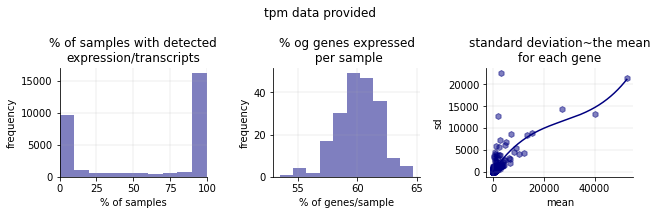

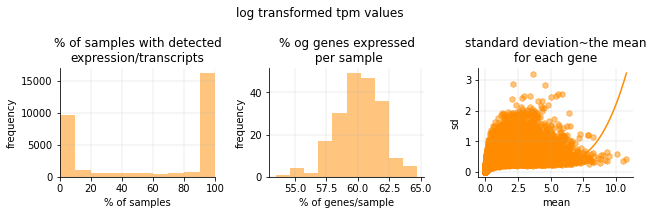

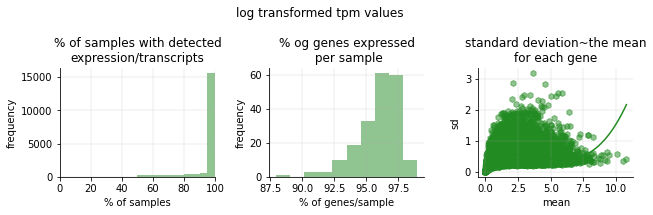

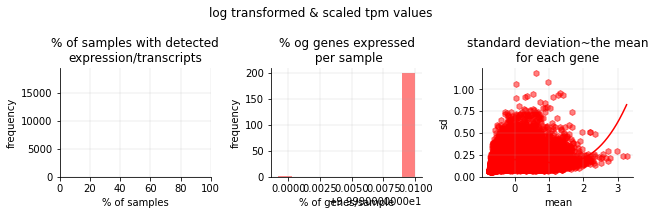

In [14]:
tpm_plots( df=data_genes, deg=3, title="tpm data provided")
tpm_plots( df=data_genes_log, title="log transformed tpm values", deg=3, color="darkorange")
tpm_plots( df=data_genes_log_filtered, title="log transformed tpm values", deg=3, color="forestgreen")
tpm_plots( df=data_genes_log_filtered_scaled,
          title="log transformed & scaled tpm values", deg=3, color="red")

__show summary table__

In [15]:
tpm_summary_raw = tpm_summary( df=data_genes)
tpm_summary_log = tpm_summary( df=data_genes_log)
tpm_summary_log_filtered = tpm_summary( df=data_genes_log_filtered)
tpm_summary_log_filtered_scaled = tpm_summary( df=data_genes_log_filtered_scaled)
tpm_summary_x_transf = tpm_summary(df=x_transf)

pd.concat([
     tpm_summary_raw.transpose(),
     tpm_summary_log.transpose(), 
     tpm_summary_log_filtered.transpose(),
     tpm_summary_log_filtered_scaled.transpose(),
     tpm_summary_x_transf.transpose()
    ],
    keys=["raw", "log", "log_filtered", "scaled", "outliers_removed"], 
    axis=1
)

raw    log  \
                                                         0      0   
sample nr                                              200    200   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.3   
mean tpm value recorded                               32.2    1.3   
max tpm value recorded                            314419.1   12.7   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.1%  60.1%   
% of genes not expressed in any sample               17.6%  17.6%   
% of genes expressed in at least 50%  of samples     59.5%  59.5%   
% of genes expressed in all samples                  43.6%  43.6%   

                                                 log_filtered  scaled  \
                                                            0       0   
sample nr                                                 200     200   
gene nr                                                 18510   18510   
- VALUES -                                                              
min tpm value recorded                                    0.0    -0.9   
median tpm value recorded                                 2.0     0.0   
mean tpm value recorded                                   2.1     0.0   
max tpm value recorded                                   12.7     5.1   
- DETECTED IN -                                                         
mean % of genes expressed per sample                    95.9%  100.0%   
% of genes not expressed in any sample                   0.0%    0.0%   
% of genes expressed in at least 50%  of samples       100.0%  100.0%   
% of genes expressed in all samples                     73.1%  100.0%   

                                                 outliers_removed  
                                                                0  
sample nr                                                     190  
gene nr                                                     18510  
- VALUES -                                                         
min tpm value recorded                                       -0.9  
median tpm value recorded                                     0.0  
mean tpm value recorded                                       0.0  
max tpm value recorded                                        5.1  
- DETECTED IN -                                                    
mean % of genes expressed per sample                       100.0%  
% of genes not expressed in any sample                       0.0%  
% of genes expressed in at least 50%  of samples           100.0%  
% of genes expressed in all samples                        100.0%

__show TPM levels for the first 100 genes__
* get some examples, to be sure that everythign is working correctly,
* and the avlues were tranformed according to expectations, 

ERRATUM: groups on yaxis are gene names

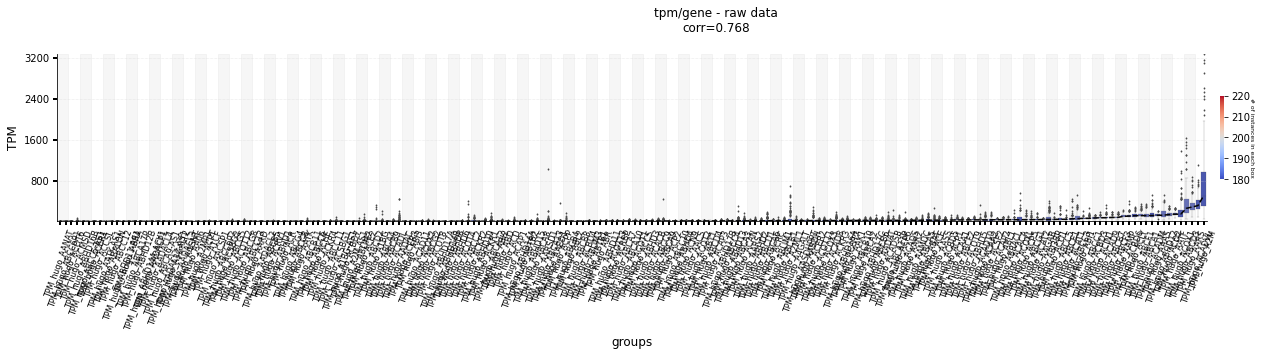

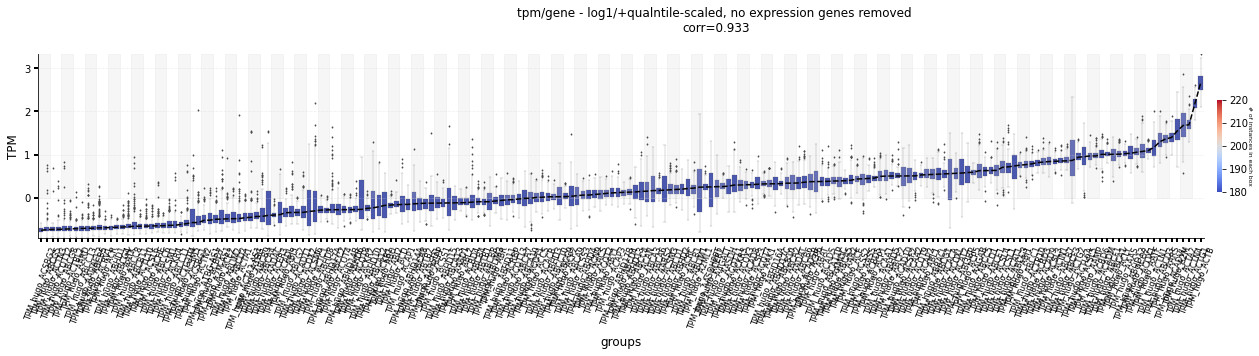

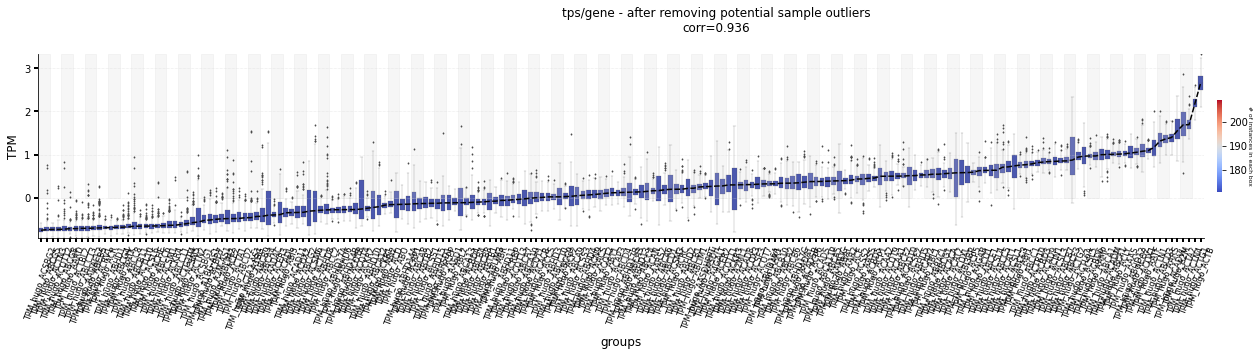

In [16]:
# how many genes to use to plot boxplots with tpm's :
n = 200

# plot tpms/gene
plot_colored_boxplot(df=data_genes, n=n, title="tpm/gene - raw data")
plot_colored_boxplot(df=data_genes_log_filtered_scaled, n=n, title="tpm/gene - log1/+qualntile-scaled, no expression genes removed ")
plot_colored_boxplot(df=x_transf, n=n, title="tps/gene - after removing potential sample outliers")

### __Step 2. Check for sample outliers__

### __Evaluate sample distances and find how many potenital outliers should be removed__

__GOAL__:   
* to assess overall similarity between samples: 
* Which samples are similar to each other, which are different? 
* Does this fit to the expectation from the experiment’s design?

__METHOD used to find potential outliers__

* __Rank-based filtering with Spearman correlation__
    * in this approach, i create an average gene expression profile for each group of samples, including potential stratificaiton, 
    * secondl, I calulate speerman rho, correlation coef, for each sample, that rank based, 
    * and I remove the samples that are below threshold, 
    * the threshold is parametrized    
* __Comment__
    * the same method is used, to provide informaiton on sample quality in prediciton pipeline



__plot similarity between samples before any tranformations and outlier removal__
* the similarity is estimated with spearman corr. coef. that is rank based, 
* clustered heatmap, shows results from pair-wise comparisons beween all samples in the dataset
* on the left site, you may also see samples classyficaiton, to target gorup, and any of the potential confouding variables, such as sex

/Users/pawel/anaconda3/envs/mlenv/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


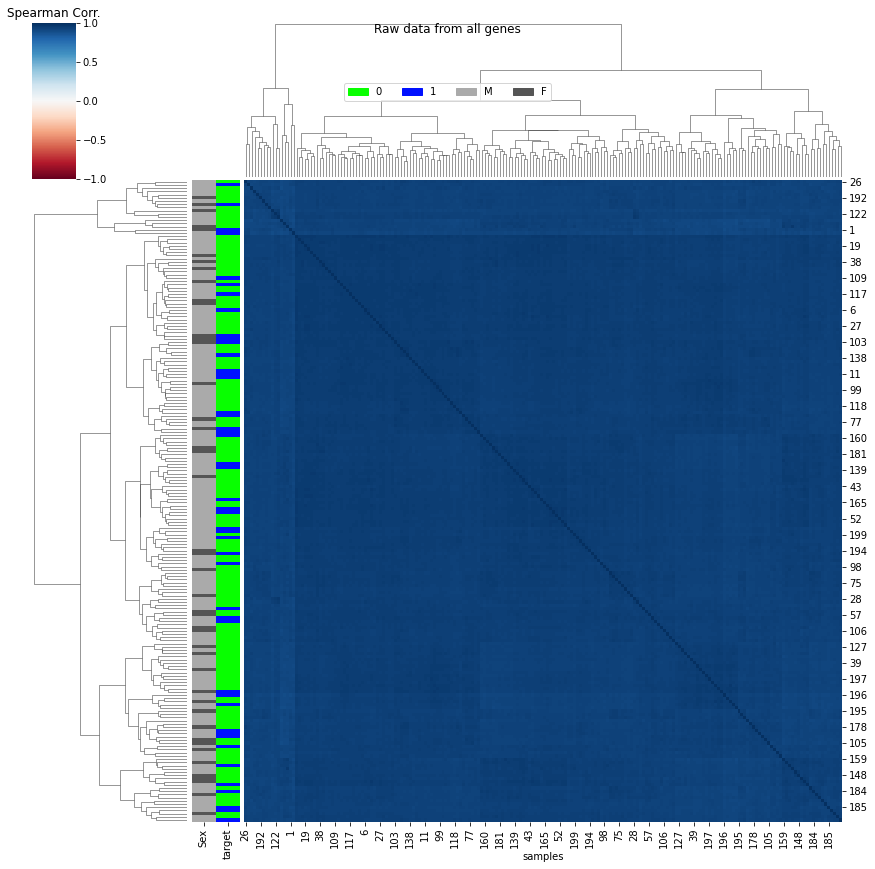

In [17]:
# similarity based on raw data from all genes
spearman_clustermap(
    df=data_genes.transpose(), 
    labels=pd.Series(target.iloc[:,0]),  #
    labels_2=pd.Series(data_cov.loc[:,"Sex"]),  #
    figsize=(12,12),
    title="Raw data from all genes"
)

### __Find potential outliers__

__Rank-based filtering with Spearman correlation__
* in this approach, i create an average gene expression profile for each group of samples, including potential stratificaiton, 
* secondl, I calulate speerman rho, correlation coef, for each sample, that rank based, 
* and I remove the samples that are below threshold, 
* the threshold is parametrized    

__Comment__
* the same method is used, to provide informaiton on sample quality in prediciton pipeline


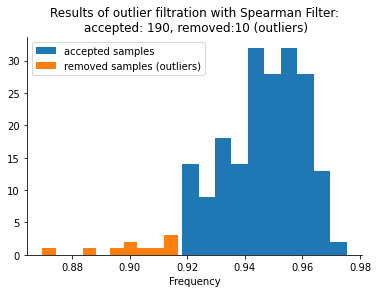

In [18]:
# plot corr. os removed, accepted sample
corr_values = sp_filter._train_samples_corr
corr_accepted = corr_values.iloc[sp_filter._train_samples_accepted]
corr_removed = corr_values.iloc[sp_filter._train_samples_removed]

# plot on hist
plt.hist(corr_accepted, label="accepted samples");
plt.hist(corr_removed, label="removed samples (outliers)");
plt.title(f"Results of outlier filtration with Spearman Filter:\n accepted: {len(corr_accepted)}, removed:{len(corr_removed)} (outliers)")
plt.xlabel("Spearm corr.\nSample tpm profil~Average tpm profile in train data")
plt.xlabel("Frequency")
plt.legend()
sns.despine()

__and again plot clustered heatmap, to see if we can fina more differences between samples, but at the same if there are no samples that are consistently different from all other samples__   
* the number of bad-quality samples ie. potenital outliers, can be controled by treshold in the preprocessing pipeline
* __TIP:__ we are especially interested to see if ligh-colored lines dissapeared from the plot


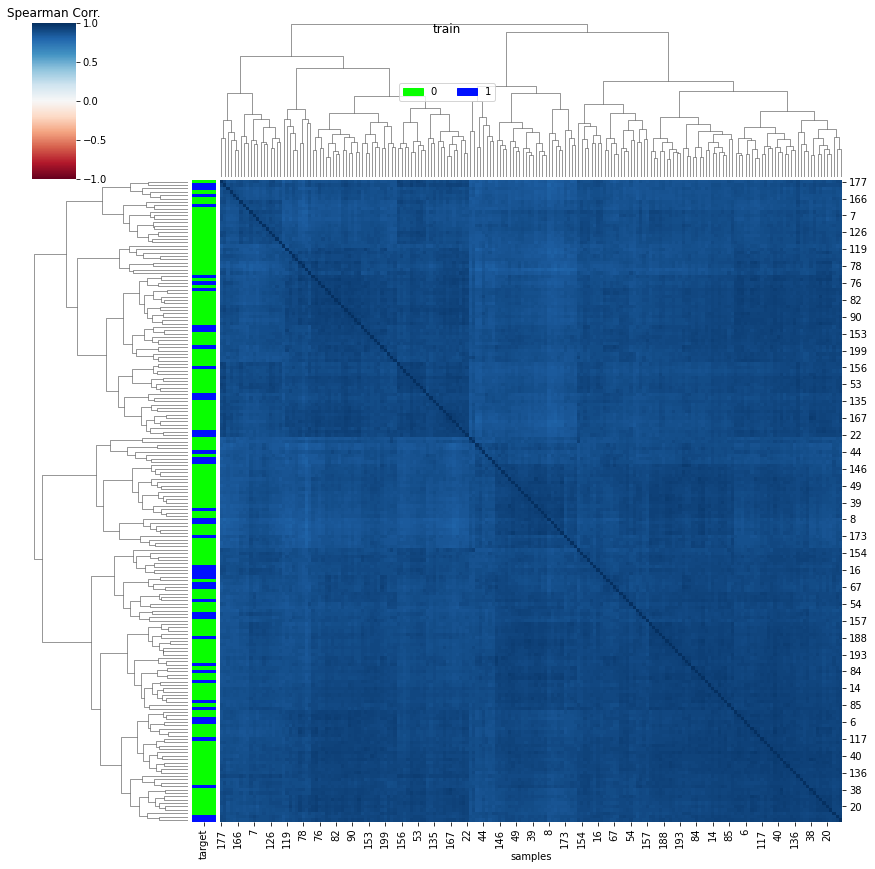

In [19]:
spearman_clustermap(
    df=x_transf.transpose(), 
    labels=y_transf,  
    n=None, 
    figsize=(12, 12),
    title="train"
)

## __PART 4. dimensionality reduction__
---
I created 2 options
* __(a) find differentially expressed genes, and use them for ML models__
* __(b) apply PCA for dimensionality reduction__

__imports__

In [20]:
from src.utils.helper_cluster_histogram import spearman_clustermap
from src.utils.helper_boxplot import colored_boxplots
from src.utils.helper_colored_boxplot import plot_colored_boxplot
from src.utils.helper_gene_expression_clustermap import gene_expression_clustermap
from src.utils.helper_PCA_plots import pca_plot_and_scree_plot
from src.utils.helper_PCA_plots import tsne_plot

### __Option (a) find differentially expressed genes, and use them for ML models__

* I using OvR applroach
* in this particular problem there are only two groups, these will be used
* statiustical test:
    * I used T-test for the means of two independent samples of scores.This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.
    * with well over 20 samples, it work similarly well to other good methods,
    * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [21]:
# inputs
x = x_transf
y = y_transf

# divide the set into two group
ttest_results=[]
log_change_results=[]
for idx in range(x.shape[1]):
    one_row = x_transf.iloc[:,idx].values
    a = one_row[y==0]
    b = one_row[y==1]
    
    # .. ttest
    ttest_results.append((stats.ttest_ind(a, b).pvalue))
    
    # log chnage
    log_change_results.append(np.abs(np.median(a)-np.median(b)))
    
# store results in nice series
ttest_results = pd.DataFrame([ttest_results,log_change_results]).transpose()
ttest_results.columns = ['pvalues', 'foldchange']
ttest_results.index = x.columns

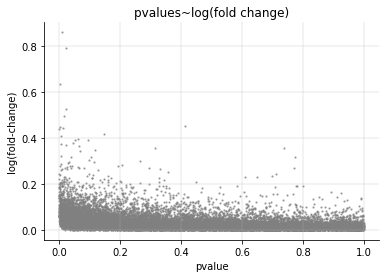

In [22]:
# qc
plt.scatter(x=ttest_results.pvalues, y=ttest_results.foldchange, 
            marker='h', alpha=0.6, s=2, color="grey")
plt.title("pvalues~log(fold change)")
plt.grid(lw=0.3)
plt.xlabel("pvalue")
plt.ylabel("log(fold-change)")
sns.despine()

__show top 10 scores_

In [23]:
ttest_results.sort_values(by="pvalues", ascending=True).head()
ttest_results.sort_values(by="foldchange", ascending=False).head(10)

pvalues  foldchange
TPM_hugo_MAGEA6     0.009936    0.860381
TPM_hugo_NLRP2      0.021133    0.789645
TPM_hugo_S100A2     0.001318    0.636841
TPM_hugo_KRT5       0.020896    0.524715
TPM_hugo_FAT2       0.015464    0.493851
TPM_hugo_GSTM1      0.412934    0.450200
TPM_hugo_IGF2BP3    0.001214    0.446394
TPM_hugo_DSC3       0.013027    0.444977
TPM_hugo_MMP10      0.000014    0.438883
TPM_hugo_LOC284379  0.146422    0.419267

__exctract 1000 genest that are the most different__
* and check then on a seasbont plot


............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 10 
differencially expressed genes
............................................................


/Users/pawel/anaconda3/envs/mlenv/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


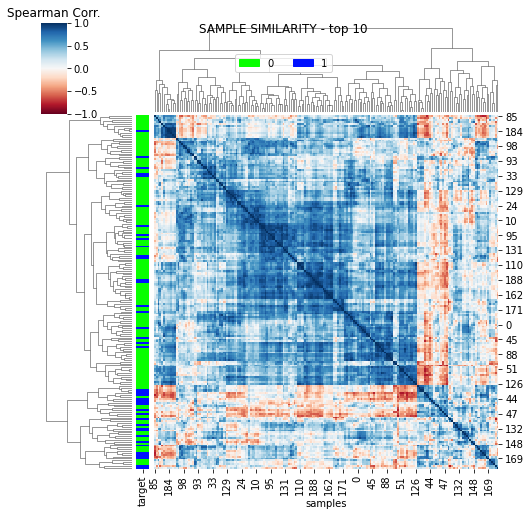

............................................................
GENE EXPRESSION IN THE TOP 
 10 differencially expressed genes
............................................................


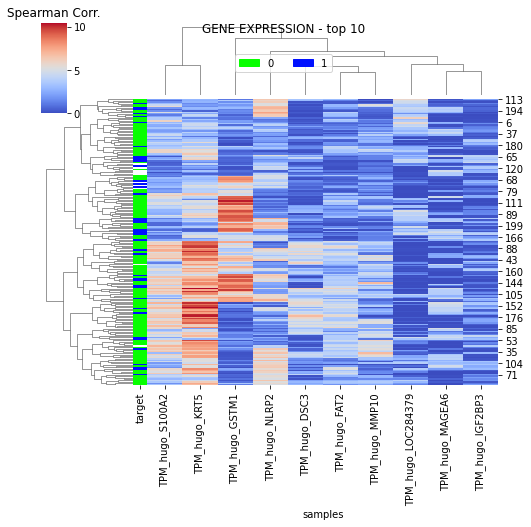

............................................................
PCA and tSNE analysis
............................................................


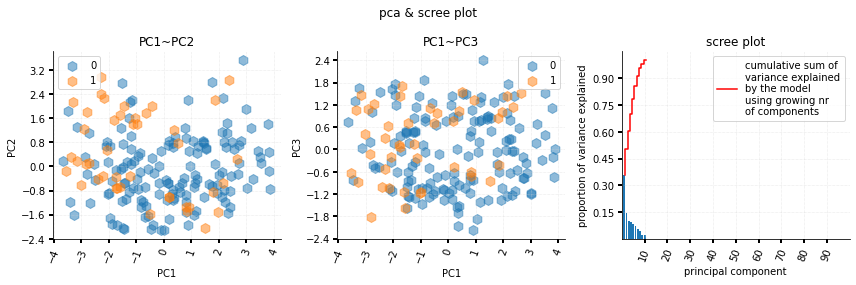

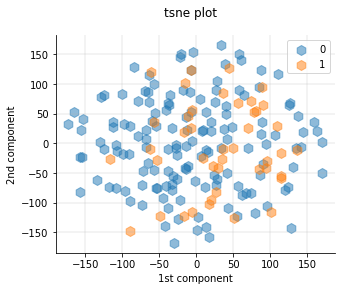

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 100 
differencially expressed genes
............................................................


/Users/pawel/anaconda3/envs/mlenv/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


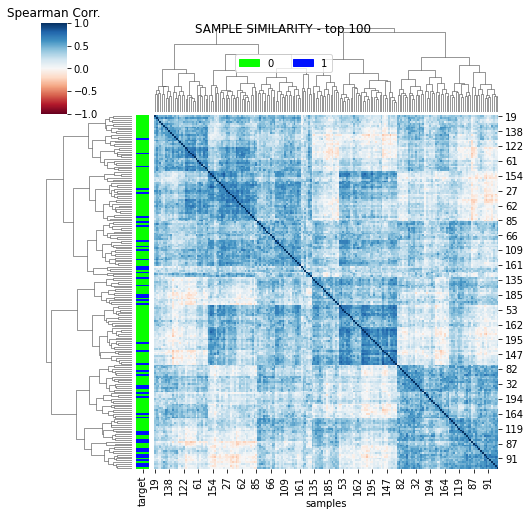

............................................................
GENE EXPRESSION IN THE TOP 
 100 differencially expressed genes
............................................................


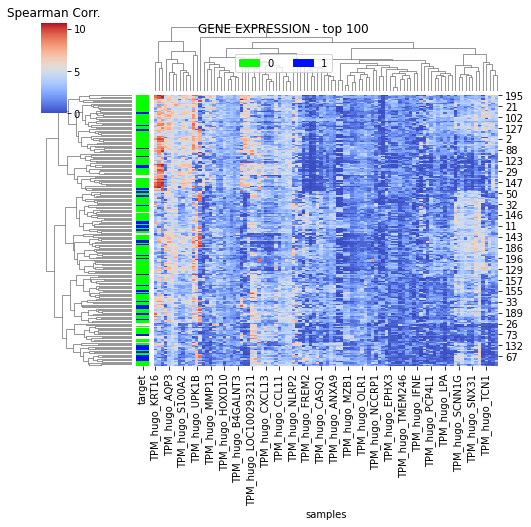

............................................................
PCA and tSNE analysis
............................................................


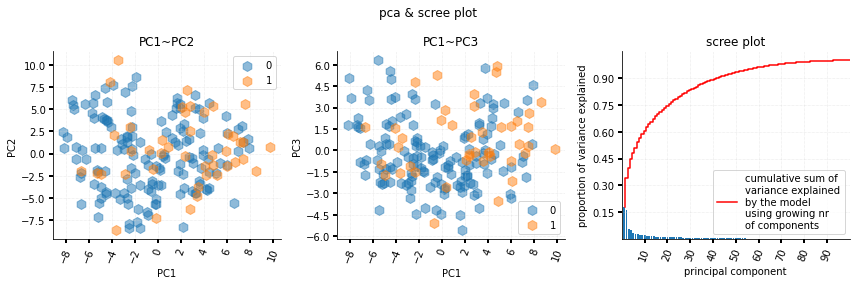

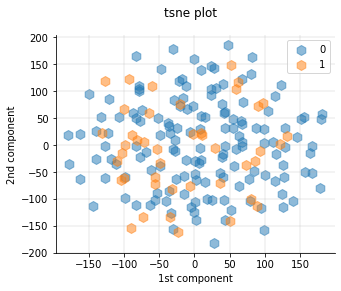

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 500 
differencially expressed genes
............................................................


/Users/pawel/anaconda3/envs/mlenv/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


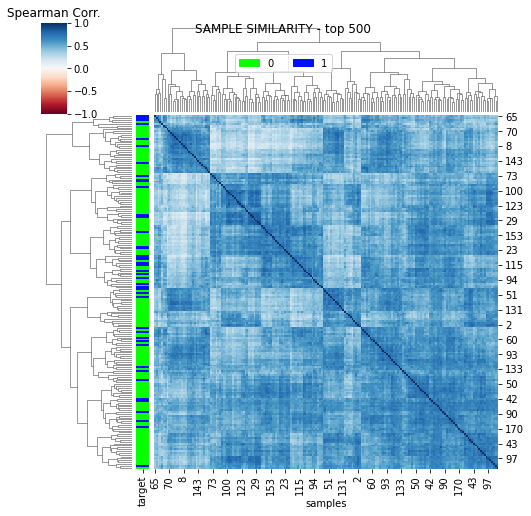

............................................................
GENE EXPRESSION IN THE TOP 
 500 differencially expressed genes
............................................................


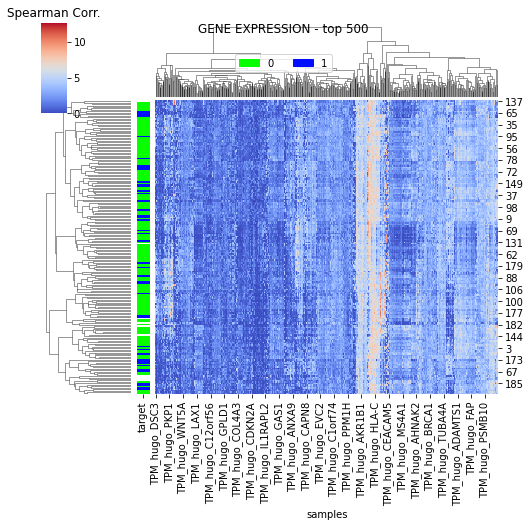

............................................................
PCA and tSNE analysis
............................................................


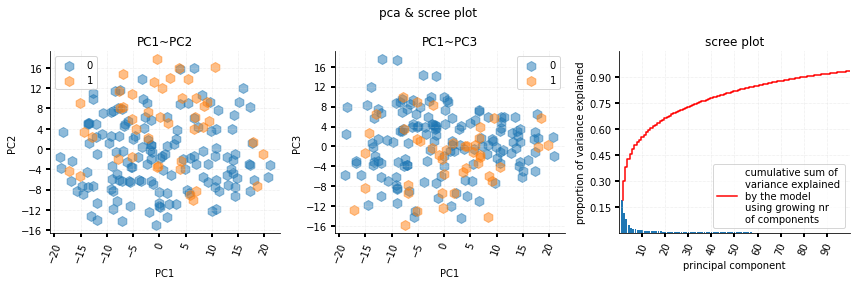

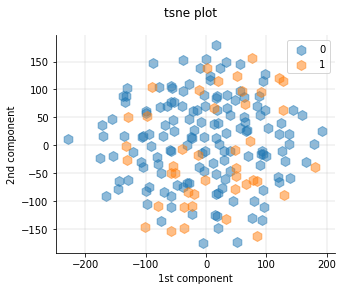

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 1000 
differencially expressed genes
............................................................


/Users/pawel/anaconda3/envs/mlenv/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


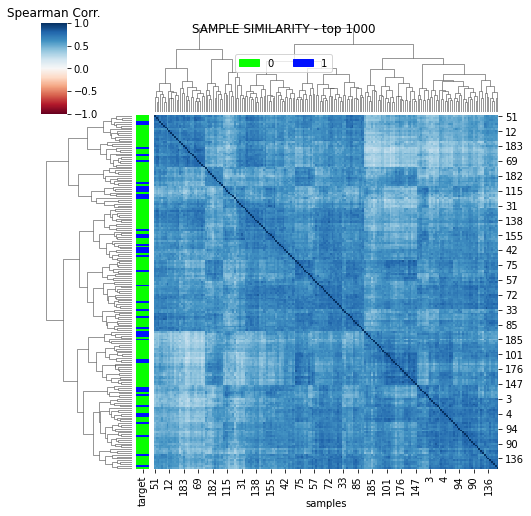

............................................................
GENE EXPRESSION IN THE TOP 
 1000 differencially expressed genes
............................................................


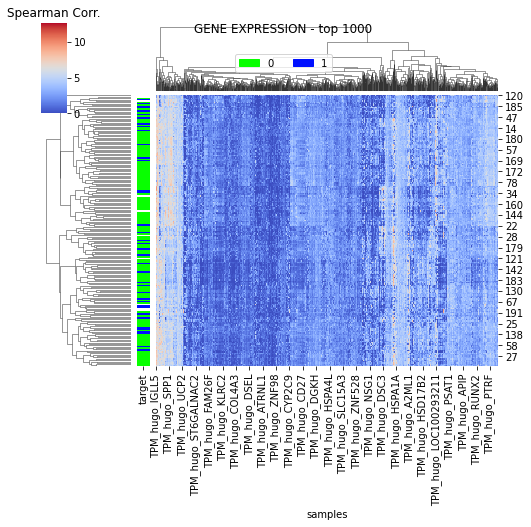

............................................................
PCA and tSNE analysis
............................................................


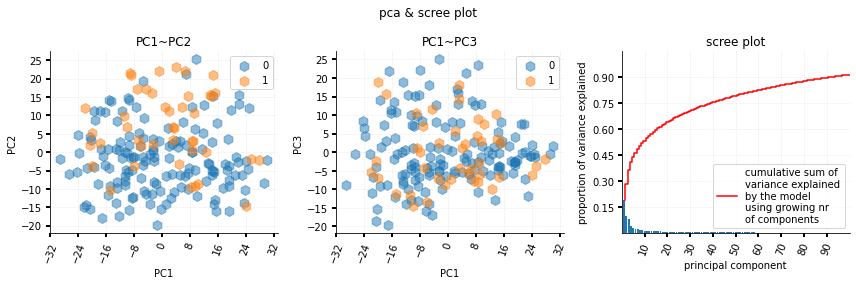

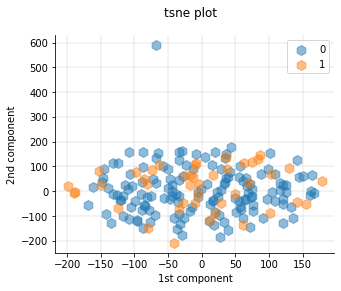

In [24]:
for top_scores in [10, 100, 500, 1000]:
    
    # get gene names
    gs_top =  ttest_results.sort_values(by="foldchange", ascending=False).index[0:top_scores]

    # crate spearma clustermap to see if these gene allows better separation between target classes
    title = f"SIMILARITY BEWEEN SAMPLES\nBASED ON GENE EXPRESSION IN THE TOP {top_scores} \ndifferencially expressed genes"
    print(f"{''.join(['.']*60)}\n{title}\n{''.join(['.']*60)}")
    spearman_clustermap(
        df=x_transf.loc[:, gs_top.values.tolist()].transpose(), 
        labels=y_transf,  
        n=None, 
        figsize=(7,7),
        title=f"SAMPLE SIMILARITY - top {top_scores}"
    )
    
    # check if the selected gene "really" have different expression
    title = f"GENE EXPRESSION IN THE TOP \n {top_scores} differencially expressed genes"
    print(f"{''.join(['.']*60)}\n{title}\n{''.join(['.']*60)}")
    gene_expression_clustermap(
        df=data_genes_log.loc[:, gs_top.values.tolist()], 
        labels=y,  
        n=None, 
        figsize=(7,7),
        title=f"GENE EXPRESSION - top {top_scores}",
        cmap='coolwarm'
    )
    
    # get gene names
    title = f"PCA and tSNE analysis"
    print(f"{''.join(['.']*60)}\n{title}\n{''.join(['.']*60)}")
    pca_plot_and_scree_plot(x_transf.loc[:, gs_top.values.tolist()], y_transf, scale="y")
    tsne_plot(x_transf.loc[:, gs_top.values.tolist()], y_transf, n_components=3)   